In [1]:
# load required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from tidepy.pred import TIDE
from sklearn.preprocessing import StandardScaler
from scipy.stats import fisher_exact, mannwhitneyu
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from scipy.stats import zscore, pearsonr
from sklearn.preprocessing import LabelEncoder

##### read data

In [21]:
melanoma = pd.read_csv("data/final_melanoma.csv", index_col = 0)
ccrcc = pd.read_csv("data/final_ccrcc.csv", index_col = 0)
nsclc = pd.read_csv("data/final_nsclc.csv", index_col = 0)
immuno_OS = pd.read_csv("data/final_immuno_OS.csv", index_col = 0)
immuno_PFS = pd.read_csv("data/final_immuno_PFS.csv", index_col = 0)
immuno = pd.read_csv("data/final_immuno.csv", index_col = 0)
lozano = pd.read_csv("data/final_lozano.csv", index_col = 0)

In [11]:
immuno_PFS.head()

,EST stromal,EST immune,EST estimate,ISTME stromal,ISTME immune,SIA,TIDE,ID,response,trt,delta,OS,cancer,PFS,delta_pfs,NetBio,score_type
0,219.268123,3111.777069,3331.045192,0.045334,0.952056,0.641026,0.179426,EA632123,NR,Anti-PD1,1.0,12.747433,ccRCC,1.839836,1,0.677829,M
1,-1371.682956,2046.880760,675.197804,-0.116789,0.967307,0.647059,0.108694,P66507-04D-Run1_S3_L001,R,Anti-PD1,0.0,55.359343,ccRCC,10.151951,0,0.680902,M
2,3132.417410,262.468237,3394.885647,-0.039825,1.132884,0.333333,0.130955,NSCLC1873,NR,Anti-PD1,NaN,NaN,NSCLC,0.047194,1,0.434745,L
3,-689.513678,4238.605012,3549.091334,0.296752,0.955343,0.577778,0.214350,G138701_RCCBMS-00036-T_v1_RNA_OnPrem,NR,Anti-PD1,1.0,13.380822,ccRCC,0.526027,1,0.931540,H
4,1705.512105,2859.377232,4564.889337,-0.057107,1.091497,0.297872,0.113082,EA639153,NR,Anti-PD1,0.0,51.186858,ccRCC,4.731006,1,0.719295,M


#### Pearson correlation and Fisher's test for combined immunotherapy cohort

In [17]:
def pearsonr_value(df, score, y, cancer = False):
    """
    Return the Pearson r for all data if cancer = False
    Return r for a specific cancer if cancer = cancer type
    """
    if cancer:
        df1 = df[df['cancer'] == cancer]
        correlation, _ = pearsonr(df1[y], df1[score])
    else:
        correlation, _ = pearsonr(df[y], df[score])
    return round(correlation,4)


def corr_plot(df, score, y, ylim = False, is_ylab = False, is_title = False, palette = {"SKCM": "#846E89","ccRCC":"#5B7288", "NSCLC": "#9D8063"}, ax = None):
    """
    Return the corrlation plot
    """
    
    if ax is None:
        fig,ax = plt.subplots()
    else:
        fig = ax.get_figure()
    
    df1 = df.dropna(subset = [y, score])
    # pearson correlation on the whole data
    corr = pearsonr_value(df1, score, y)

    # only include samples with survival data
    sns.scatterplot(x = score, y = y, hue = 'cancer', palette = palette, data = df1, ax = ax)
    ax.set_xlabel("")
    ax.set_title("")
    xticks = ax.get_xticks()
    if xticks[0] >=50:
        xticks_rounded = np.round(xticks, decimals=0)
        ax.set_xticklabels([f'{tick:.0f}' for tick in xticks_rounded], weight = 'bold', size = 18)
    else:
        xticks_rounded = np.round(xticks, decimals=1)
        ax.set_xticklabels([f'{tick:.1f}' for tick in xticks_rounded], weight = 'bold', size = 18)
    ax.set_yticklabels(ax.get_yticks() ,weight = 'bold', size = 18)

    corr_ccrcc = pearsonr_value(df1, score, y, "ccRCC")
    if y == "OS":
        corr_skcm = pearsonr_value(df1, score, y, "SKCM")
        ax.text(0.01, 0.95, f'r = {corr:.2f}\n$r_{{SKCM}}$ = {corr_skcm}\n$r_{{ccRCC}}$ = {corr_ccrcc}', transform = ax.transAxes, 
                fontsize = 18, fontweight = "bold", verticalalignment = 'top', horizontalalignment = 'left')
    else:
        corr_nsclc = pearsonr_value(df1, score, y, "NSCLC")
        ax.text(0.01, 0.95, f'r = {corr:.2f}\n$r_{{ccRCC}}$ = {corr_ccrcc}\n$r_{{NSCLC}}$ = {corr_nsclc}', transform = ax.transAxes, 
                fontsize = 18, fontweight = "bold", verticalalignment = 'top', horizontalalignment = 'left')

    if is_ylab:
        ax.set_ylabel(y, weight = "bold", size = 20)
        font_properties = fm.FontProperties(weight='bold', size=20)
        ax.legend(loc='upper right', prop = font_properties)
        ax.set_ylim(ylim[0], ylim[1])
    else:
        ax.set_ylabel("")
        ax.get_legend().remove()
        ax.set_yticks([])

    if is_title:
        ax.set_title(score, weight = "bold", size = 20)

    return ax, fig

In [15]:
def assign_type(score, med = False):
    """ 
    Classify samples based on the score
    if med = True, classify samples into three groups: high > 75%, intermediate 25% - 75%, low < 25%
    else classify into two groups based on the median
    """
    if med:
        q25 = score.quantile(0.25)
        q75 = score.quantile(0.75)
        def get_type(value):
            if value >= q75:
                return 'H'
            elif value <= q25:
                return 'L'
            else:
                return 'M'
    
    else:
        q5 = score.quantile(0.5)
        def get_type(value):
            if value >= q5:
                return 'H'
            else:
                return 'L'
    
    return score.apply(get_type)



def response_bar(df, name, score, response, ylim = False, is_ylab = False, is_title = False, med = False, treatment = "", ax = None, color_map = {"R": "#9DAEB6", "NR": "#3D5C6F"}):
    """ 
    Plot the stacked barplot of high and low groups
    Perform Fisher's exact test to compare the distribution
    """

    score_type = assign_type(df[score], med)
    df['score_type'] = score_type
    df1 = df[df['score_type'] != 'M'] # only consider samples in group high and low
    counts_bl = pd.crosstab(df1['score_type'], df1[response])
    counts_bl.index.name = None
    #print(counts_bl)

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    # plotting the stack barplot
    counts_bl.index = ['High', 'Low']
    counts_bl.plot(kind='bar', stacked=True, color=[color_map[col] for col in counts_bl.columns], ax = ax)
    ax.set_ylim(0, 100)
    ax.set_yticks(np.arange(0,100,20))
    ax.set_xticklabels(counts_bl.index, rotation=0, ha="center", weight = 'bold', size = 18)
    ax.set_yticklabels(ax.get_yticks() ,weight = 'bold', size = 18)

    # perform fisher exact test
    contingency_table_bl = counts_bl.values
    odds_ratio_bl, p_value_bl = fisher_exact(contingency_table_bl)
    n = len(df1[score])
    ax.set_title("")
    if is_ylab:
        ax.set_ylabel(name + " Counts", fontsize = 20, fontweight = 'bold')
        #ax.legend(['NR', 'R'])
        font_properties = fm.FontProperties(weight='bold', size=18)
        ax.legend(['NR', 'R'], loc='upper right', prop = font_properties)
        ax.text(0.01, 0.95, f'P = {round(p_value_bl, 4)}\nn = {n}', fontsize = 18, fontweight = "bold", transform = ax.transAxes,
                verticalalignment = 'top', horizontalalignment = 'left')
    else:
        ax.set_ylabel("")
        ax.get_legend().remove()
        ax.set_yticks([])
        ax.text(0.01, 0.95, f'P = {round(p_value_bl, 4)}\n', fontsize = 18, fontweight = "bold", transform = ax.transAxes,
                verticalalignment = 'top', horizontalalignment = 'left')
    
    if is_title:
        ax.set_title(score, weight = 'bold', size = 20)

    return fig, ax

/var/folders/pn/18v3yr7d4jq5y_qt83z7v7_w0000gn/T/ipykernel_41969/1231615760.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{tick:.1f}' for tick in xticks_rounded], weight = 'bold', size = 18)
/var/folders/pn/18v3yr7d4jq5y_qt83z7v7_w0000gn/T/ipykernel_41969/1231615760.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks() ,weight = 'bold', size = 18)
/var/folders/pn/18v3yr7d4jq5y_qt83z7v7_w0000gn/T/ipykernel_41969/1231615760.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{tick:.1f}' for tick in xticks_rounded], weight = 'bold', size = 18)
/var/folders/pn/18v3yr7d4jq5y_qt83z7v7_w0000gn/T/ipykernel_41969/1231615760.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks() ,weight = 'bold', size = 18)
/var/folders/pn/18v3yr7d4jq5y_qt83z7v7_w0000gn/T/i

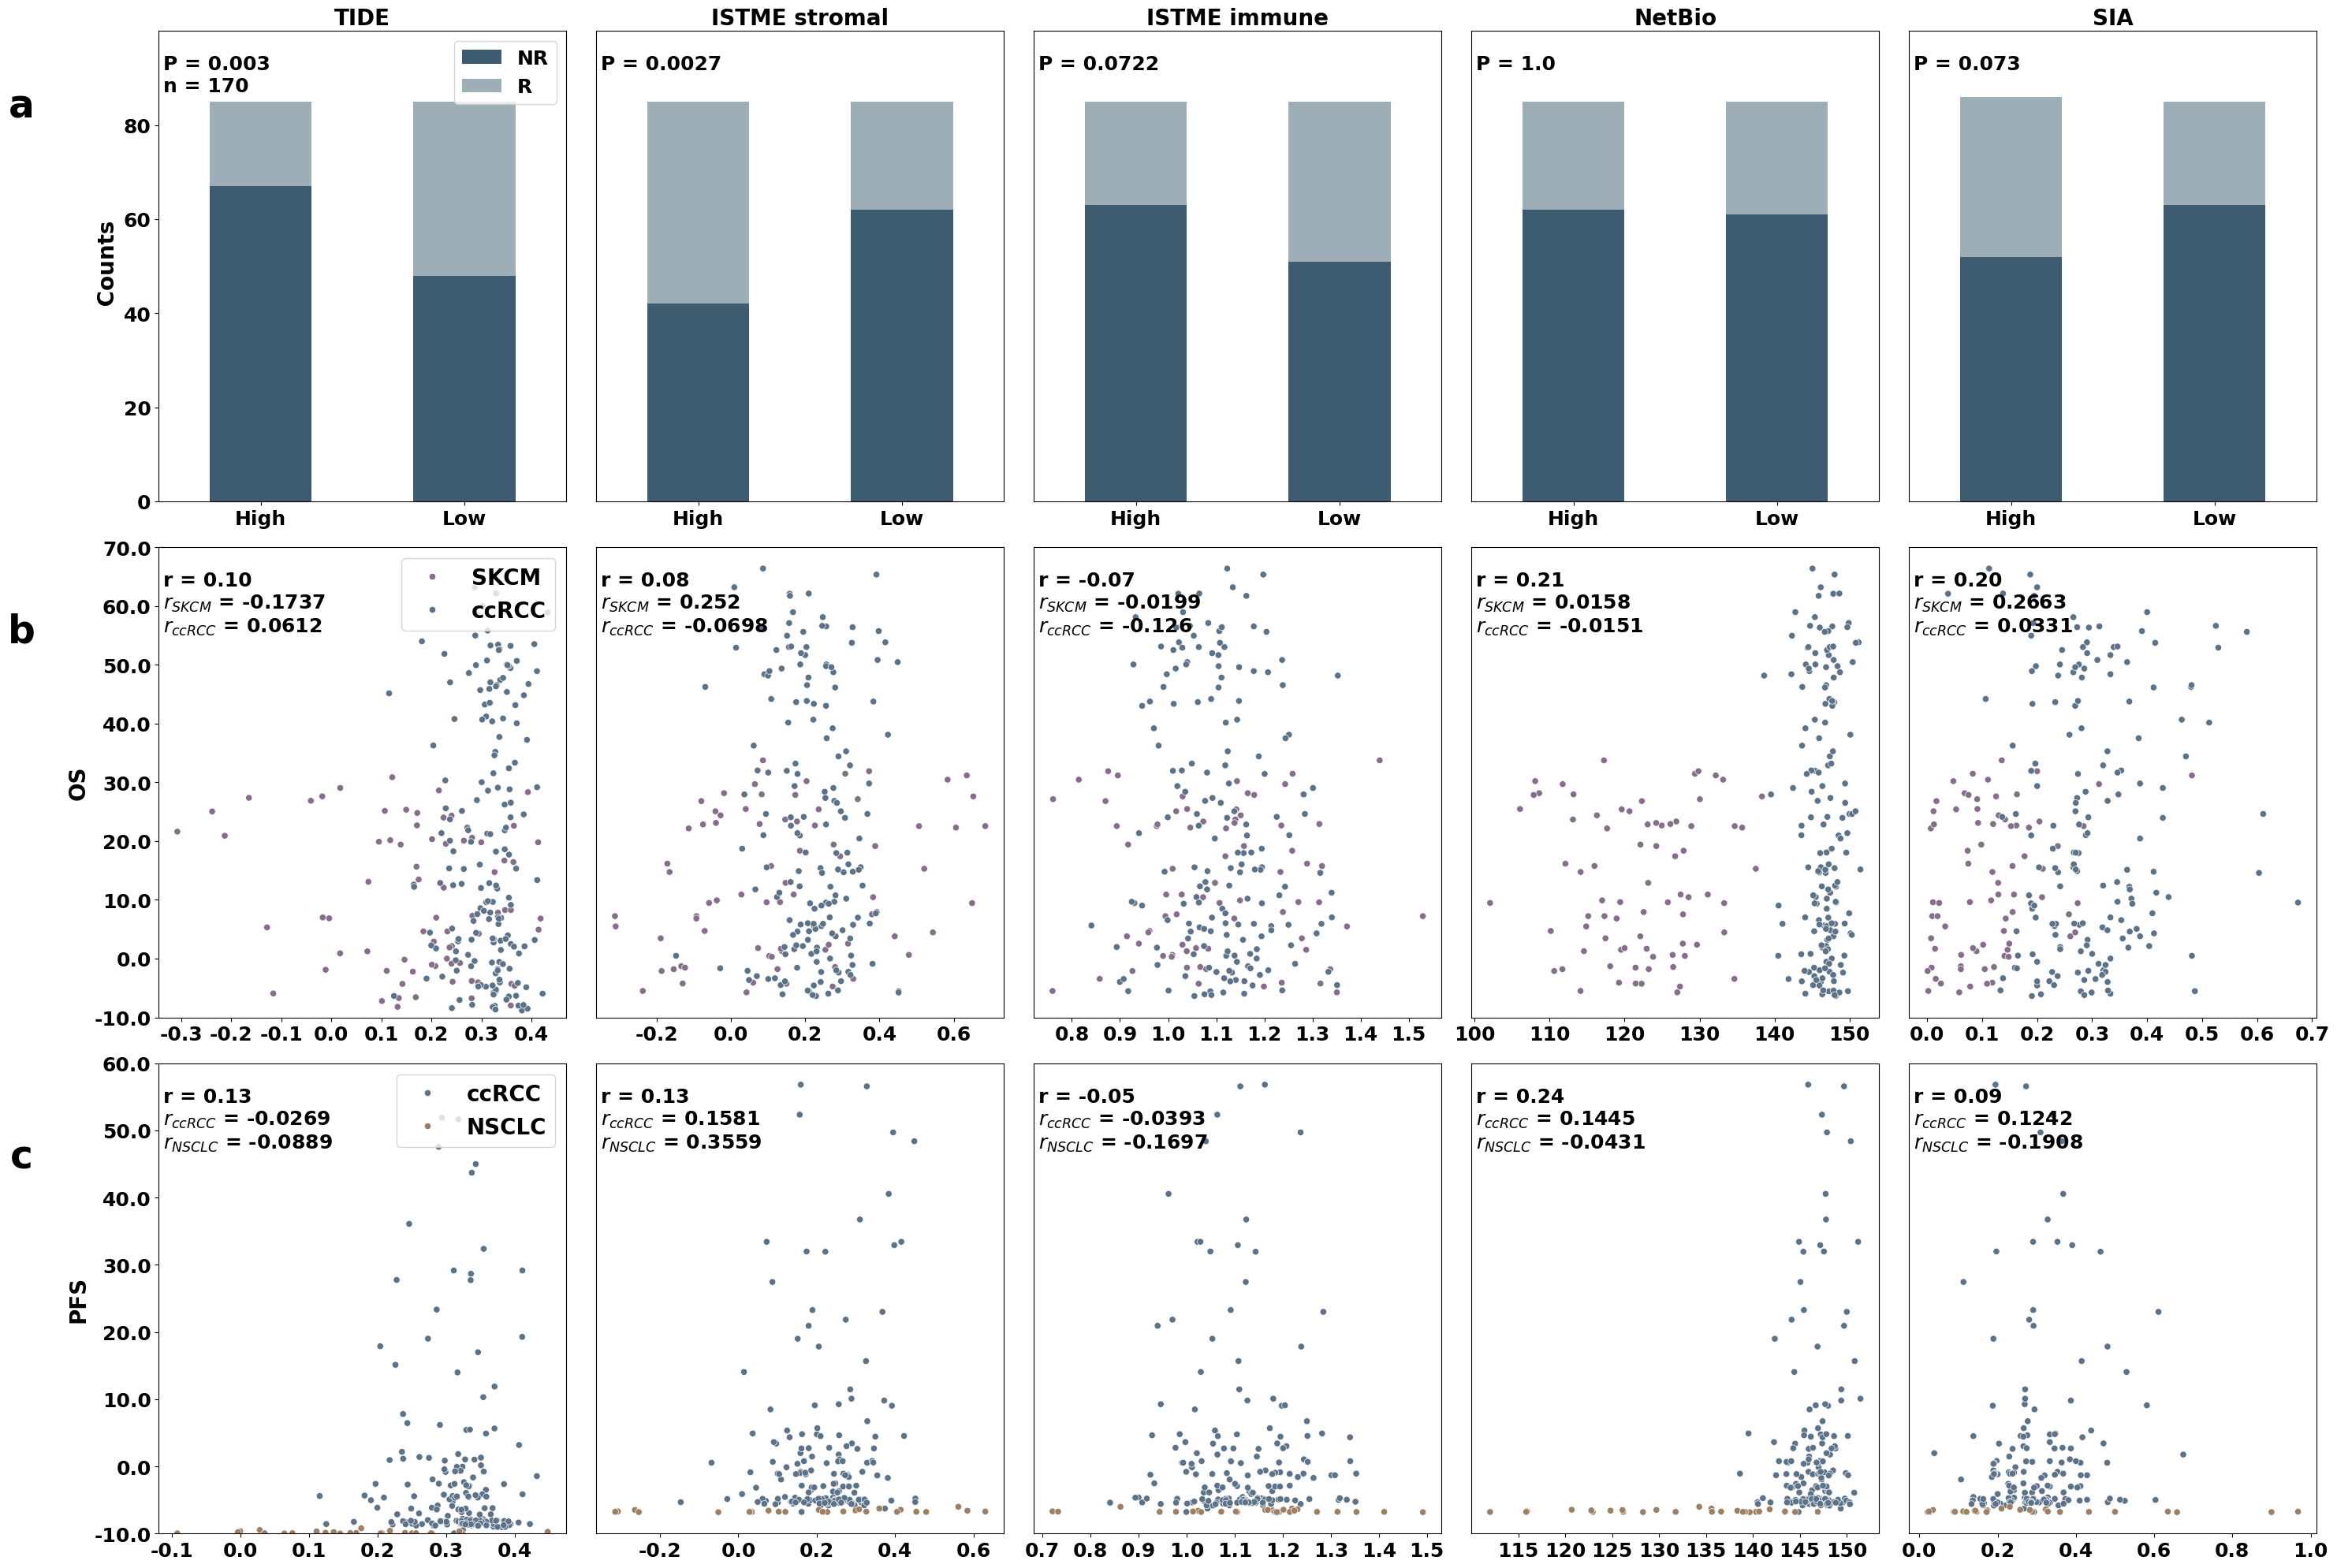

In [19]:
fig, axs = plt.subplots(3, 5, figsize=(29, 20), constrained_layout=True)

response_bar(immuno, '', 'TIDE', 'response', is_ylab = True, med = True, is_title = True, ax = axs[0,0]) 
response_bar(immuno, '', 'ISTME stromal', 'response', med = True, is_title = True, ax = axs[0,1])
response_bar(immuno, '', 'ISTME immune', 'response', med = True, is_title = True, ax = axs[0,2]) 
response_bar(immuno, '', 'NetBio', 'response', med = True, is_title = True, ax = axs[0,3]) 
response_bar(immuno, '', 'SIA', 'response', med = True, is_title = True, ax = axs[0,4]) 


# correlation plot
corr_plot(immuno, score = "TIDE", y = "OS", ylim = [0,80], is_ylab = True, ax = axs[1,0])
corr_plot(immuno, score = "ISTME stromal", y = "OS", ax = axs[1,1])
corr_plot(immuno, score = "ISTME immune", y = "OS", ax = axs[1,2])
corr_plot(immuno, score = "NetBio", y = "OS", ax = axs[1,3])
corr_plot(immuno, score = "SIA", y = "OS", ax = axs[1,4])

# 2nd row: pfs
corr_plot(immuno, score = "TIDE", y = "PFS", ylim = [0,70], is_ylab = True, ax = axs[2,0])
corr_plot(immuno, score = "ISTME stromal", y = "PFS", ax = axs[2,1])
corr_plot(immuno, score = "ISTME immune", y = "PFS", ax = axs[2,2])
corr_plot(immuno, score = "NetBio", y = "PFS", ax = axs[2,3])
corr_plot(immuno, score = "SIA", y = "PFS", ax = axs[2,4])

row_labels = ['a', 'b', 'c']
for i, label in enumerate(row_labels):
    y_pos = 1.0 - i * (1 / len(row_labels)) - 0.07
    fig.text(-0.015, y_pos, label, fontsize=35, ha='center', va='center', fontweight='bold')

plt.subplots_adjust(left=0.15)

plt.tight_layout()
plt.show()

#### Fig 2

In [22]:
def roc_analysis(df, cancer_name, ax = None, is_xlab = False, is_ylab = False, score_list = ['TIDE', 'ISTME stromal', 'ISTME immune', 'NetBio', 'SIA']):
    """
    Plot ROC curves for multiple scores within the dataframe.
    
    Parameters:
    - df: DataFrame containing 'response' and score columns.
    """
    if ax is None:
        fig,ax = plt.subplots()
    else:
        fig = ax.get_figure()

        
    df1 = df[~df['response'].isna()]
    plt.figure(figsize=(8, 6))  # Create a figure for the plot
    legend_list = ['TIDE', 'IS stromal', 'IS immune', 'NetBio', 'SIA']

    for i in range(len(score_list)):
        # Remove rows with missing values in the current score column
        df2 = df1[~df1[score_list[i]].isna()]
        
        # Compute FPR, TPR, and thresholds for the ROC curve
        fpr, tpr, thresholds = roc_curve(
            df2['response'].apply(lambda x: 1 if x == "R" else 0),
            df2[score_list[i]]
        )
        
        # Compute the Area Under the Curve (AUC)
        roc_auc = auc(fpr, tpr)
        
        # Plot the ROC curve
        ax.plot(fpr, tpr, lw=2, label=f'{legend_list[i]} ({roc_auc:.2f})')

    # Plot the diagonal line (random classifier)
    ax.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')

    # Set plot limits and labels
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.1])

    if is_xlab:
        ax.set_xlabel('FPR', fontsize = 14, fontweight = "bold")
        ax.set_xticklabels(ax.get_xticklabels(), fontsize = 14, fontweight = "bold")
    else:
        ax.set_xticklabels([])
    
    if is_ylab:
        ax.set_ylabel('TPR', fontsize = 14, fontweight = "bold")
        ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14, fontweight = "bold")
    else:
        ax.set_yticklabels([])

    ax.set_title(cancer_name, fontsize = 16, fontweight = "bold")
    font_properties = fm.FontProperties(weight='bold', size=12)
    legend = ax.legend(loc="upper left", bbox_to_anchor=(0, 1), prop = font_properties, title = "AUC", title_fontsize = 12)
    legend.get_title().set_fontweight('bold')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)

    return ax, fig

/var/folders/pn/18v3yr7d4jq5y_qt83z7v7_w0000gn/T/ipykernel_41969/207366719.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14, fontweight = "bold")
/var/folders/pn/18v3yr7d4jq5y_qt83z7v7_w0000gn/T/ipykernel_41969/207366719.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize = 14, fontweight = "bold")
/var/folders/pn/18v3yr7d4jq5y_qt83z7v7_w0000gn/T/ipykernel_41969/207366719.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14, fontweight = "bold")
/var/folders/pn/18v3yr7d4jq5y_qt83z7v7_w0000gn/T/ipykernel_41969/207366719.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize = 14, fontweight = "bold")
/var/folders/pn/18v3yr7d4jq5y_qt83z7v7_w0000gn/T/ipykern

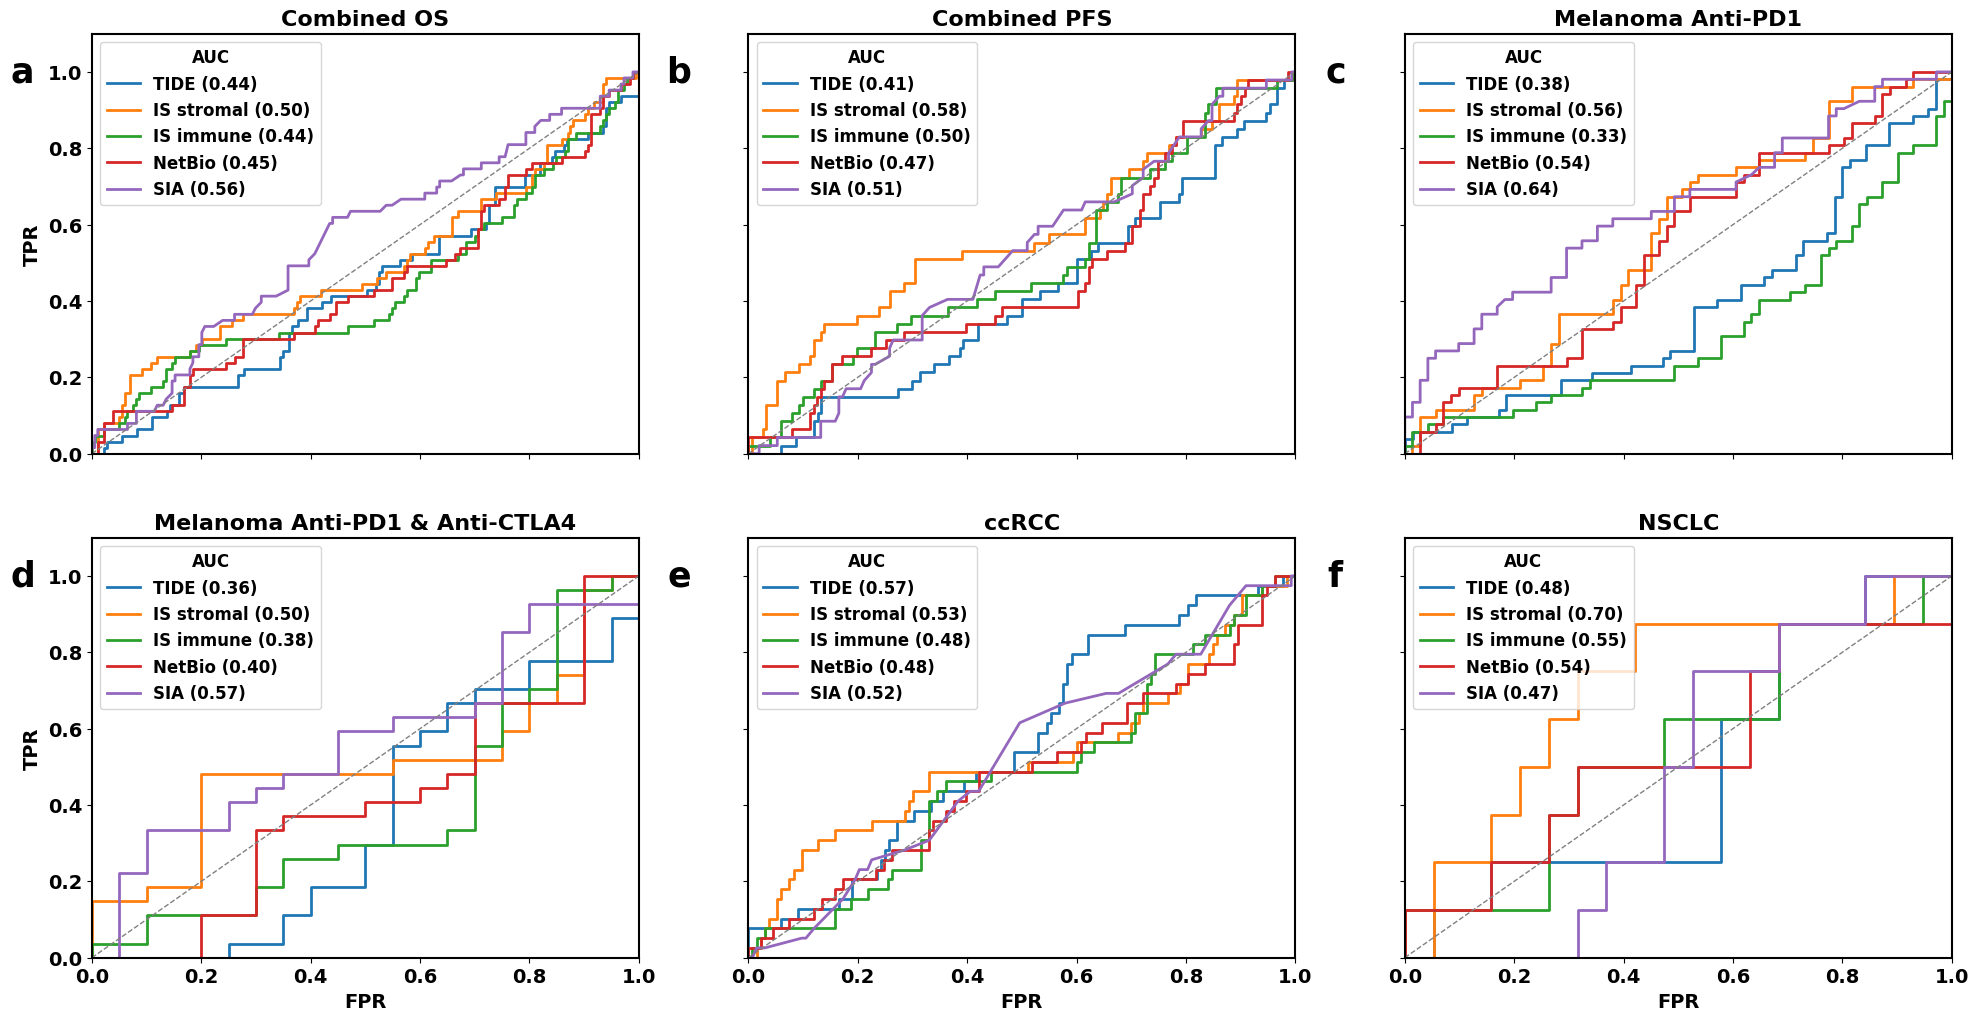

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [23]:
fig2, axs2 = plt.subplots(2, 3, figsize=(24, 12))
roc_analysis(immuno_OS, "Combined OS", ax = axs2[0,0], is_ylab = True)
axs2[0,0].annotate("a", xy=(0, 1),xytext=(-50, 0), textcoords='offset points',
        ha='center', va='center',fontsize=25, fontweight='bold')
roc_analysis(immuno_PFS, "Combined PFS", ax = axs2[0,1])
axs2[0,1].annotate("b", xy=(0, 1),xytext=(-50, 0), textcoords='offset points',
        ha='center', va='center',fontsize=25, fontweight='bold')
roc_analysis(melanoma, "Melanoma Anti-PD1", ax = axs2[0,2])
axs2[0,2].annotate("c", xy=(0, 1),xytext=(-50, 0), textcoords='offset points',
        ha='center', va='center',fontsize=25, fontweight='bold')
roc_analysis(lozano, "Melanoma Anti-PD1 & Anti-CTLA4", ax = axs2[1,0], is_xlab = True, is_ylab = True)
axs2[1,0].annotate("d", xy=(0, 1),xytext=(-50, 0), textcoords='offset points',
        ha='center', va='center',fontsize=25, fontweight='bold')
roc_analysis(ccrcc, "ccRCC", ax = axs2[1,1], is_xlab = True)
axs2[1,1].annotate("e", xy=(0, 1),xytext=(-50, 0), textcoords='offset points',
        ha='center', va='center',fontsize=25, fontweight='bold')
roc_analysis(nsclc, "NSCLC", ax = axs2[1,2], is_xlab = True)
axs2[1,2].annotate("f", xy=(0, 1),xytext=(-50, 0), textcoords='offset points',
        ha='center', va='center',fontsize=25, fontweight='bold')
plt.tight_layout()
plt.show()

#### Fig 3

In [24]:
def km_survival(df, time, delta, score, ylab, is_combined = False, show_ylab = False, med = False, is_xlab = False, is_title = False, ax = None, custom_palette = ["#547AC0", "#898988", "#F6C957"]):#["#3D5C6F", "#9DAEB6"]dark blue: "#6699CC"
    """ 
    Plot the K-M survival curves
    - time: survival time in months
    - delta: vital status
    - score: scoring method being analyzed
    """

    score_type = assign_type(df[score], med)
    df['score_type'] = score_type
    # remove NAs for unknown vital status and survival time
    df1 = df[~df[delta].isna()]
    df1 = df1[~df1[time].isna()]
    kmf_H = KaplanMeierFitter()
    kmf_L = KaplanMeierFitter()

    
    if ax is None:
        fig,ax = plt.subplots()
    else:
        fig = ax.get_figure()
    

    # Fit the model for each group
    kmf_H.fit(durations=df1[df1['score_type'] == 'H'][time], event_observed=df1[df1['score_type'] == 'H'][delta], label='H')
    kmf_L.fit(durations=df1[df1['score_type'] == 'L'][time], event_observed=df1[df1['score_type'] == 'L'][delta], label='L')

    n_H = df1[df1['score_type'] == 'H'].shape[0]
    n_L = df1[df1['score_type'] == 'L'].shape[0]
    
    # Plot the survival curves
    kmf_H.plot_survival_function(show_censors = True, color=custom_palette[0], ci_show=False, ax = ax)

    # plot intermediate group for the combined immunotherapy data
    if is_combined:
        kmf_M = KaplanMeierFitter()
        kmf_M.fit(durations=df1[df1['score_type'] == 'M'][time], event_observed=df1[df1['score_type'] == 'M'][delta], label='M')
        kmf_M.plot_survival_function(show_censors = True, color=custom_palette[2], ci_show=False, ax = ax)
    
    kmf_L.plot_survival_function(show_censors = True, color=custom_palette[1], ci_show=False, ax = ax)

    # perform log-rank test to the high and low groups
    df1[time] = pd.to_numeric(df1[time], errors='coerce')
    df1[delta] = pd.to_numeric(df1[delta], errors='coerce')
    results = logrank_test(df1[df1['score_type'] == 'H'][time], df1[df1['score_type'] == 'L'][time], event_observed_A=df1[df1['score_type'] == 'H'][delta], event_observed_B=df1[df1['score_type'] == 'L'][delta])

    # Add title and labels
    n = df1.shape[0]
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel(ylab, fontsize = 14, fontweight = 'bold')
    ax.set_ylim(0,1.1)
    xticks = ax.get_xticks()
    xticks_rounded = np.round(xticks, decimals=0)
    ax.set_xticklabels([f'{tick:.0f}' for tick in xticks_rounded], weight = 'bold', size = 14)
    ax.set_yticklabels(["0.0","0.2", "0.4", "0.6", "0.8", "1.0"] ,weight = 'bold', size = 14)

    if show_ylab:
        ax.set_ylabel(ylab, fontsize = 20, fontweight = 'bold')
        ax.text(0.6, 0.95, f'P = {results.p_value:.4f}\nn = {n}\nn_H = {n_L}\nn_L = {n_H}', transform = ax.transAxes, 
            fontsize = 18, verticalalignment = 'top', horizontalalignment = 'left', fontweight = "bold")
        font_properties = fm.FontProperties(weight='bold', size=16)
        ax.legend(loc='lower left', prop = font_properties)
    else:
        ax.set_ylabel("")
        ax.text(0.6, 0.95, f'P = {results.p_value:.4f}\nn_H = {n_L}\nn_L = {n_H}', transform = ax.transAxes, 
            fontsize = 18, verticalalignment = 'top', horizontalalignment = 'left', fontweight = "bold")
        ax.get_legend().remove()
    
    if is_xlab:
        ax.set_xlabel("Time(Months)", fontsize = 20, fontweight = "bold")
    if is_title:
        ax.set_title(score, fontweight = 'bold', fontsize = 20)


    return ax, fig

/var/folders/pn/18v3yr7d4jq5y_qt83z7v7_w0000gn/T/ipykernel_41969/1854454105.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{tick:.0f}' for tick in xticks_rounded], weight = 'bold', size = 14)
/var/folders/pn/18v3yr7d4jq5y_qt83z7v7_w0000gn/T/ipykernel_41969/1854454105.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0.0","0.2", "0.4", "0.6", "0.8", "1.0"] ,weight = 'bold', size = 14)
/var/folders/pn/18v3yr7d4jq5y_qt83z7v7_w0000gn/T/ipykernel_41969/1854454105.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{tick:.0f}' for tick in xticks_rounded], weight = 'bold', size = 14)
/var/folders/pn/18v3yr7d4jq5y_qt83z7v7_w0000gn/T/ipykernel_41969/1854454105.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0.0","0.2", "0.4", "0.6", "0.8", "1.0"] ,weight = 'bold', size = 14

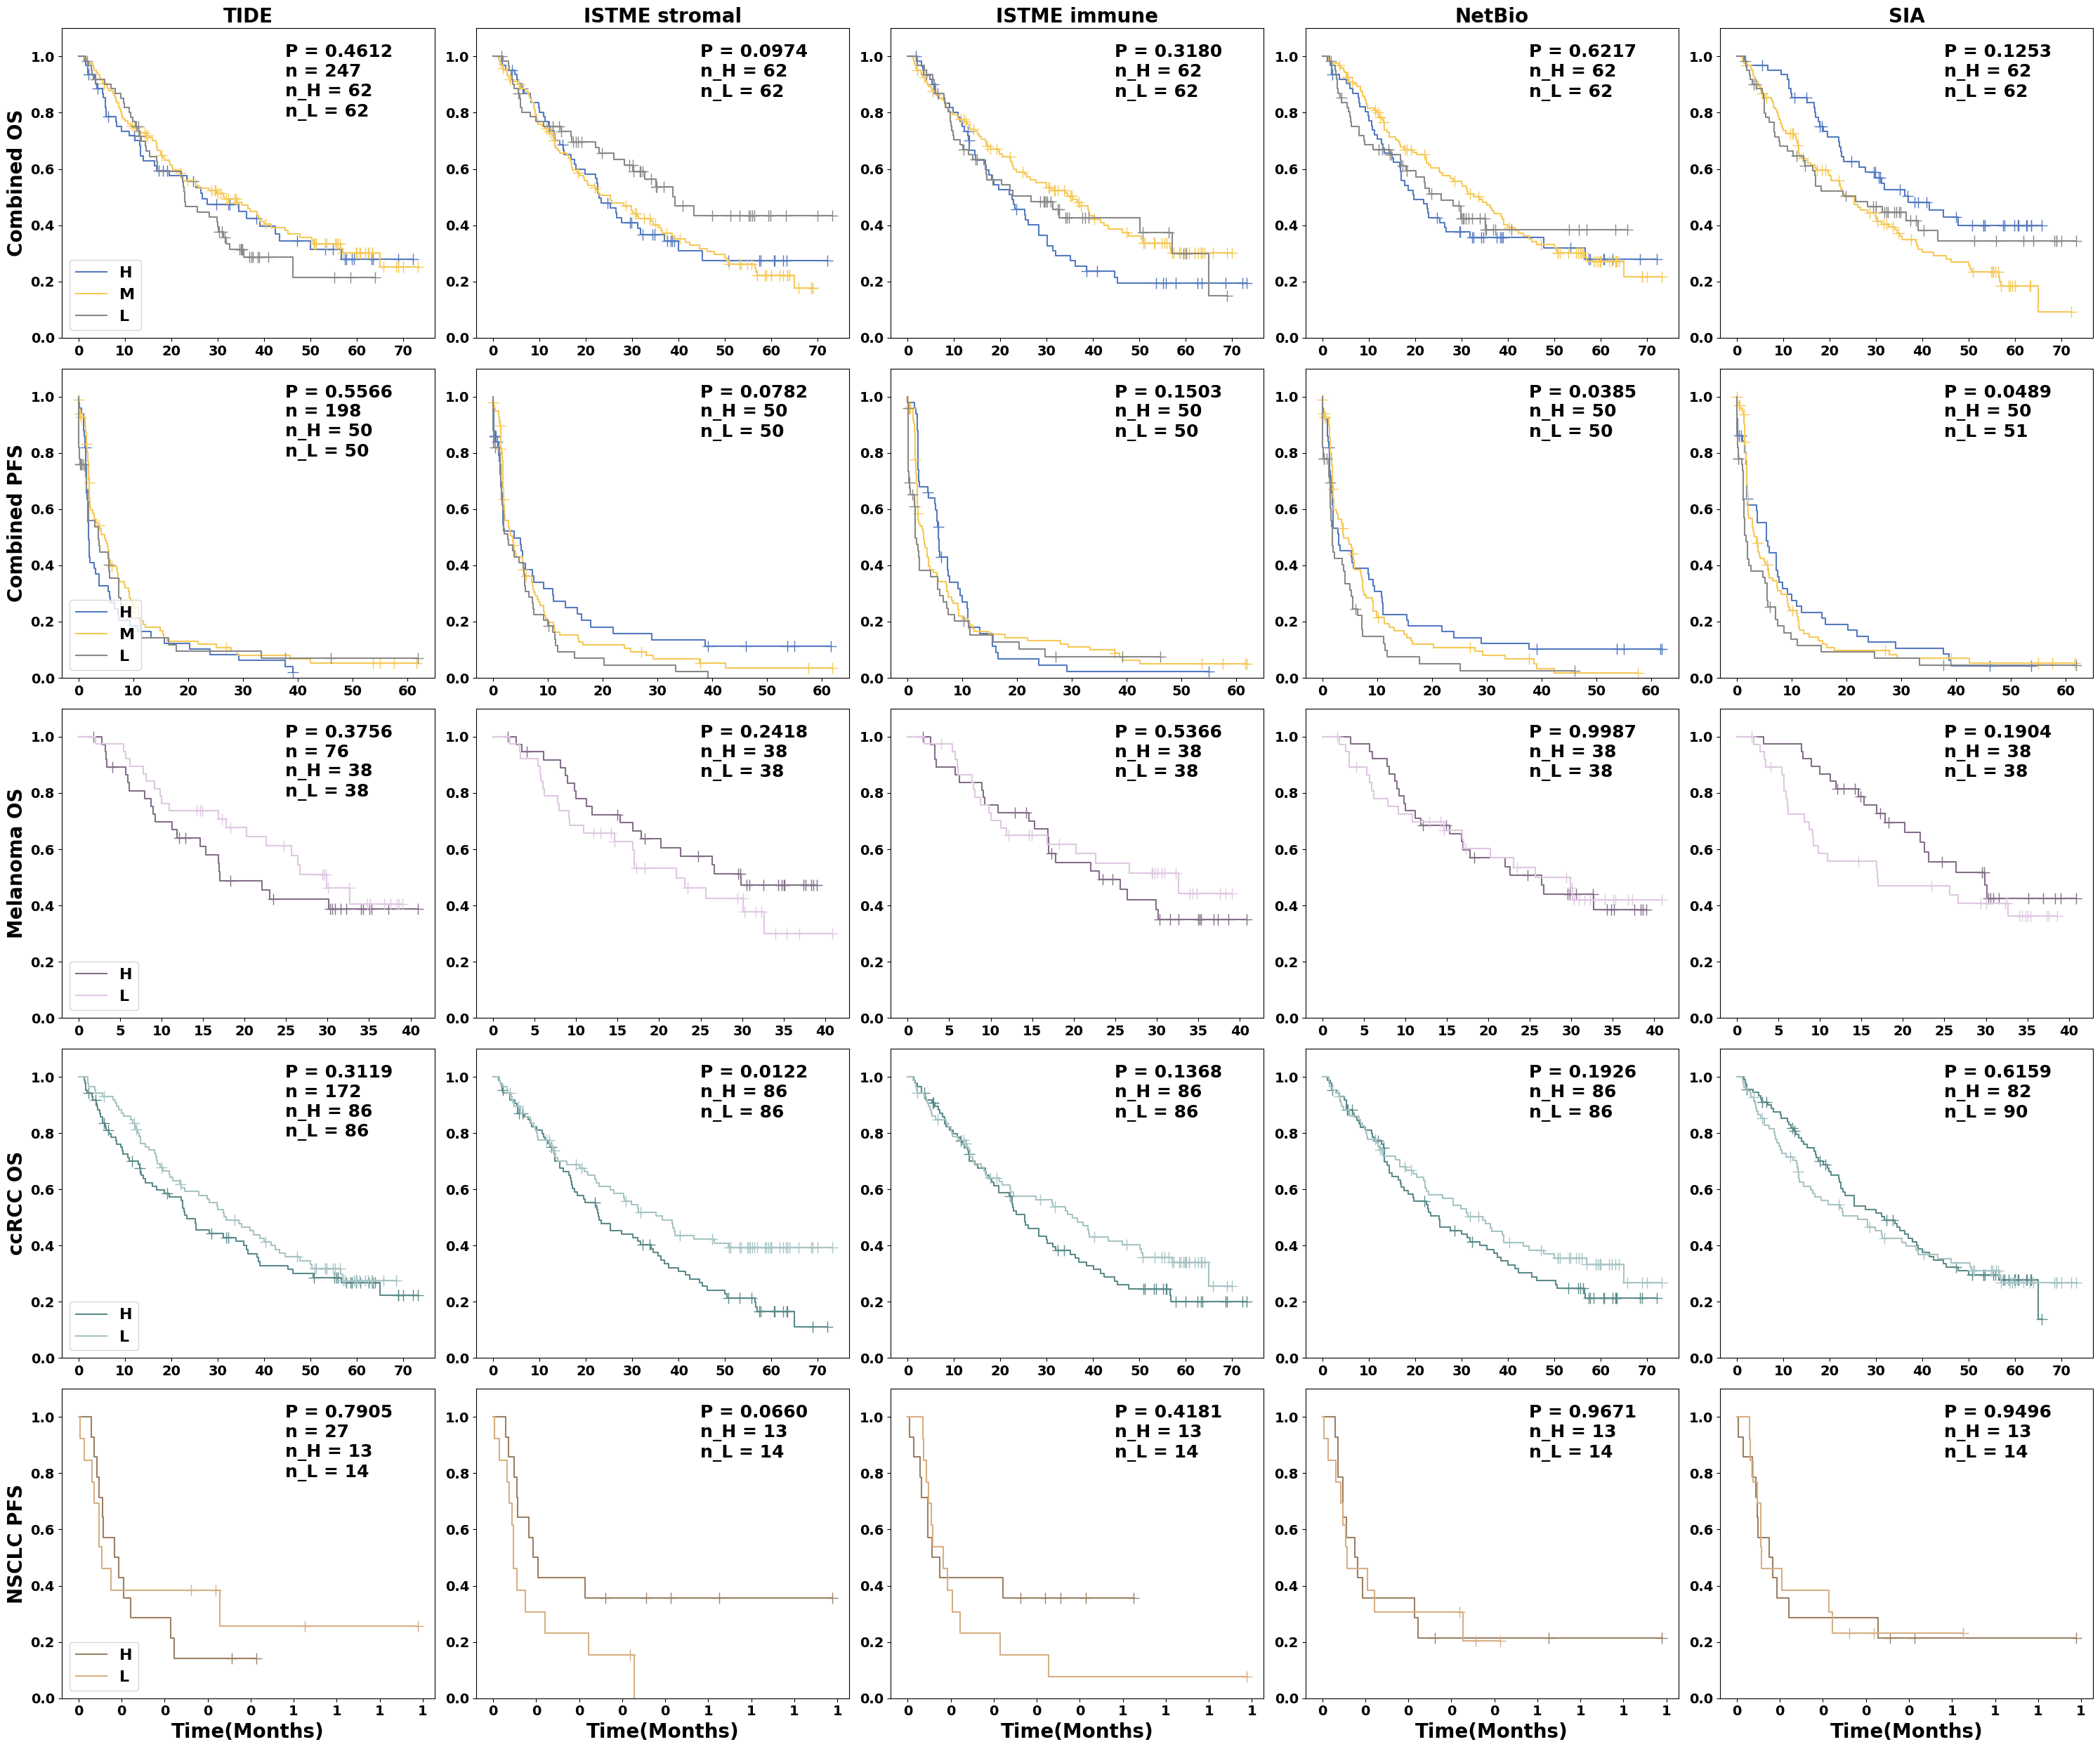

In [25]:
fig3, axs3 = plt.subplots(5, 5, figsize=(30, 25), constrained_layout=True)

# 1st row: immuno OS
km_survival(immuno_OS, "OS", "delta", "TIDE", "Combined OS", is_combined = True, show_ylab = True, med = True, is_title = True, ax = axs3[0,0])
km_survival(immuno_OS, "OS", "delta", "ISTME immune", "OS", is_combined = True, med = True, is_title = True, ax = axs3[0,2])
km_survival(immuno_OS, "OS", "delta", "ISTME stromal", "OS", is_combined = True, med = True, is_title = True, ax = axs3[0,1])
km_survival(immuno_OS, "OS", "delta", "NetBio", "OS", is_combined = True, med = True, is_title = True, ax = axs3[0,3])
km_survival(immuno_OS, "OS", "delta", "SIA", "OS", is_combined = True, med = True, is_title = True, ax = axs3[0,4])

# 2nd row: immuno PFS
km_survival(immuno_PFS, "PFS", "delta_pfs", "TIDE", "Combined PFS", is_combined = True, show_ylab = True, med = True, ax = axs3[1,0])
km_survival(immuno_PFS, "PFS", "delta_pfs", "ISTME immune", "PFS", is_combined = True, med = True, ax = axs3[1,2])
km_survival(immuno_PFS, "PFS", "delta_pfs", "ISTME stromal", "PFS", is_combined = True, med = True, ax = axs3[1,1])
km_survival(immuno_PFS, "PFS", "delta_pfs", "NetBio", "PFS", is_combined = True, med = True, ax = axs3[1,3])
km_survival(immuno_PFS, "PFS", "delta_pfs", "SIA", "PFS", is_combined = True, med = True, ax = axs3[1,4])

# 3rd row: melanoma 
km_survival(melanoma.dropna(subset = "OS"), "OS", "delta", "TIDE", "Melanoma OS", show_ylab = True, 
            ax = axs3[2,0], custom_palette = ["#846E89", "#E0C7E3"])
km_survival(melanoma.dropna(subset = "OS"), "OS", "delta", "ISTME immune", "OS", 
            ax = axs3[2,2], custom_palette = ["#846E89", "#E0C7E3"])
km_survival(melanoma.dropna(subset = "OS"), "OS", "delta", "ISTME stromal", "OS", 
            ax = axs3[2,1], custom_palette = ["#846E89", "#E0C7E3"])
km_survival(melanoma.dropna(subset = "OS"), "OS", "delta", "NetBio", "OS", 
            ax = axs3[2,3], custom_palette = ["#846E89", "#E0C7E3"])
km_survival(melanoma.dropna(subset = "OS"), "OS", "delta", "SIA", "OS", 
            ax = axs3[2,4], custom_palette = ["#846E89", "#E0C7E3"])


# 4th row: ccRCC 
km_survival(ccrcc, "OS", "delta", "TIDE", "ccRCC OS", show_ylab = True, 
            ax = axs3[3,0], custom_palette = ["#5C8A8A", "#A7C4C4"])
km_survival(ccrcc, "OS", "delta", "ISTME immune", "OS", ax = axs3[3,2], custom_palette = ["#5C8A8A", "#A7C4C4"])
km_survival(ccrcc, "OS", "delta", "ISTME stromal", "OS", ax = axs3[3,1], custom_palette = ["#5C8A8A", "#A7C4C4"])
km_survival(ccrcc, "OS", "delta", "NetBio", "OS", ax = axs3[3,3], custom_palette = ["#5C8A8A", "#A7C4C4"])
km_survival(ccrcc, "OS", "delta", "SIA", "OS", ax = axs3[3,4], custom_palette = ["#5C8A8A", "#A7C4C4"])

# 5th row: NSCLC 
km_survival(nsclc, "PFS", "delta_pfs", "TIDE", "NSCLC PFS", show_ylab = True, is_xlab = True,
            ax = axs3[4,0], custom_palette = ["#9D8063", "#D7AF83"])
km_survival(nsclc, "PFS", "delta_pfs", "ISTME immune", "PFS", is_xlab = True, ax = axs3[4,2], custom_palette = ["#9D8063", "#D7AF83"])
km_survival(nsclc, "PFS", "delta_pfs", "ISTME stromal", "PFS", is_xlab = True, ax = axs3[4,1], custom_palette = ["#9D8063", "#D7AF83"])
km_survival(nsclc, "PFS", "delta_pfs", "NetBio", "PFS", is_xlab = True, ax = axs3[4,3], custom_palette = ["#9D8063", "#D7AF83"])
km_survival(nsclc, "PFS", "delta_pfs", "SIA", "PFS", is_xlab = True, ax = axs3[4,4], custom_palette = ["#9D8063", "#D7AF83"])

row_labels = ['a', 'b', 'c', 'd', 'e']
for i, label in enumerate(row_labels):
    y_pos = 1.0 - i * (1 / len(row_labels)) - 0.07
    fig2.text(-0.015, y_pos, label, fontsize=35, ha='center', va='center', fontweight='bold')

plt.subplots_adjust(left=0.15)

plt.tight_layout()
plt.show()

#### Fig 4

In [26]:
def box_resp(df, score, name, is_ylab = False, is_title = False, is_xlab = False, ax = None, col_palette = {"R": "#8BCBF1", "NR": "#498AC7"}):
    """ 
    Boxplots to compare the distribution of scores in responders vs non-responders
    """
    
    if ax is None:
        fig,ax = plt.subplots()
    else:
        fig = ax.get_figure()
    
    # remove outliers
    q_h = df[score].quantile(0.95)
    q_l = df[score].quantile(0.05)
    df1 = df[(df[score] <= q_h) & (df[score] >= q_l)]

    # boxplots with scatters
    sns.boxplot(ax = ax, x='response', y=score, data=df1, fill = False, palette = col_palette, showfliers = False, order=["R", "NR"])
    sns.stripplot(ax = ax, x='response', y=score, data=df1, palette = col_palette, alpha=0.5, jitter=True, order = ["R", "NR"])

    # mann-whitney u test
    responder_scores = df1[df1['response'] == 'R'][score]
    non_responder_scores = df1[df1['response'] == 'NR'][score]
    stat, p = mannwhitneyu(responder_scores, non_responder_scores) # p returns nan if the two distributions are the same
    # if p is nan, assign p to 1
    if np.isnan(p):
        p = 1.0000
    
    if is_title:
        ax.set_title(score, weight = "bold", size = 14)
    else:
        ax.set_title("")


    n = len(df1[score])
    ax.set_xlabel('')
    ax.set_xticklabels([])
    ax.set_ylabel("")
    ax.set_yticklabels(np.round(ax.get_yticks(),2) ,weight = 'bold', size = 14)
    ax.text(0.01, 0.95, f'P = {p:.4f}', transform = ax.transAxes, 
            fontsize = 14, fontweight = "bold",verticalalignment = 'top', horizontalalignment = 'left')

    if is_ylab:
        ax.set_ylabel(name, fontsize = 14, fontweight = 'bold')
        ax.text(0.01, 0.95, f'P = {p:.4f}\nn = {n}', transform = ax.transAxes, 
            fontsize = 14, fontweight = "bold", verticalalignment = 'top', horizontalalignment = 'left')
    
    if is_xlab:
        ax.set_xlabel('')
        ax.set_xticklabels(["R", "NR"], weight = 'bold', size = 14)
    
    return ax, fig

/var/folders/pn/18v3yr7d4jq5y_qt83z7v7_w0000gn/T/ipykernel_41969/2590205763.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax = ax, x='response', y=score, data=df1, fill = False, palette = col_palette, showfliers = False, order=["R", "NR"])
/var/folders/pn/18v3yr7d4jq5y_qt83z7v7_w0000gn/T/ipykernel_41969/2590205763.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(ax = ax, x='response', y=score, data=df1, palette = col_palette, alpha=0.5, jitter=True, order = ["R", "NR"])
/var/folders/pn/18v3yr7d4jq5y_qt83z7v7_w0000gn/T/ipykernel_41969/2590205763.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(),2) ,we

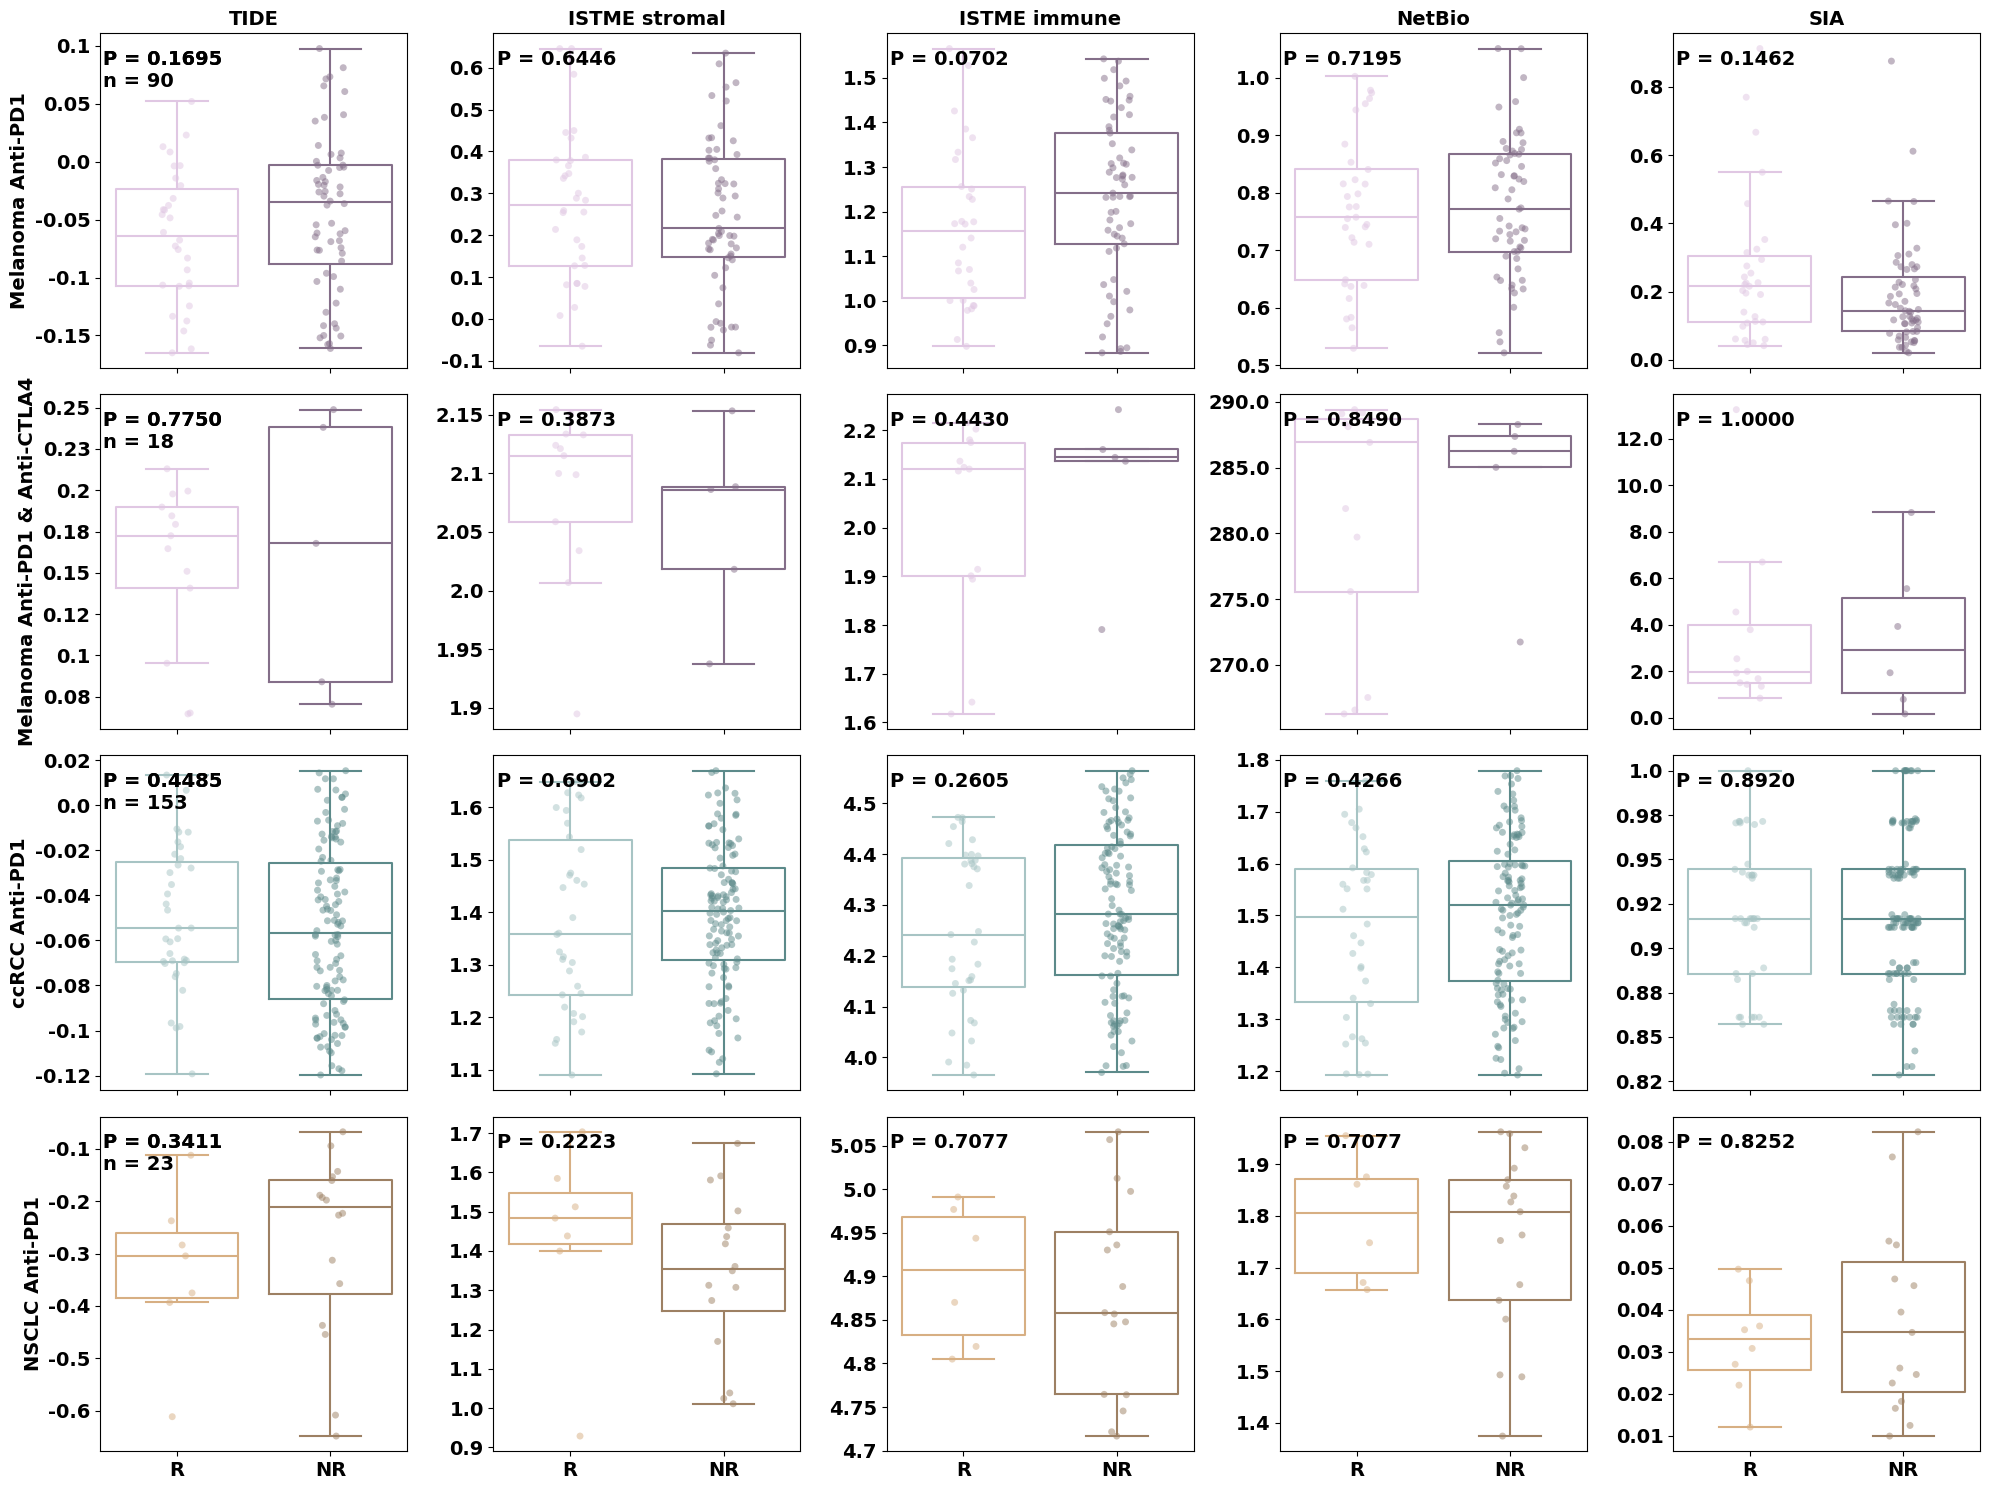

In [27]:
ccrcc['SIA'] = ccrcc['SIA'].astype(float)

fig4, axs4 = plt.subplots(4, 5, figsize=(20, 15), constrained_layout=True)

# 1st row: skcm anti-PD1
box_resp(melanoma[melanoma['trt'] == 'Anti-PD1'], "TIDE", "Melanoma Anti-PD1", 
         is_ylab = True, is_title = True, ax = axs4[0,0], col_palette = {"R": "#E0C7E3", "NR": "#846E89"})
box_resp(melanoma[melanoma['trt'] == 'Anti-PD1'], "ISTME immune", "Melanoma Anti-PD1", is_title = True, 
         ax = axs4[0,2], col_palette = {"R": "#E0C7E3", "NR": "#846E89"})
box_resp(melanoma[melanoma['trt'] == 'Anti-PD1'], "ISTME stromal", "Melanoma Anti-PD1", is_title = True, 
         ax = axs4[0,1], col_palette = {"R": "#E0C7E3", "NR": "#846E89"})
box_resp(melanoma[melanoma['trt'] == 'Anti-PD1'], "NetBio", "Melanoma Anti-PD1", is_title = True, 
         ax = axs4[0,3], col_palette = {"R": "#E0C7E3", "NR": "#846E89"})
box_resp(melanoma[melanoma['trt'] == 'Anti-PD1'], "SIA", "Melanoma Anti-PD1", is_title = True, 
         ax = axs4[0,4], col_palette = {"R": "#E0C7E3", "NR": "#846E89"})

# 2nd row: skcm combine
box_resp(lozano[lozano['trt'] == 'Combination'], "TIDE", "Melanoma Anti-PD1 & Anti-CTLA4", is_ylab = True, 
         ax = axs4[1,0], col_palette = {"R": "#E0C7E3", "NR": "#846E89"})
box_resp(lozano[lozano['trt'] == 'Combination'], "ISTME immune", "Melanoma Combination", 
         ax = axs4[1,2], col_palette = {"R": "#E0C7E3", "NR": "#846E89"})
box_resp(lozano[lozano['trt'] == 'Combination'], "ISTME stromal", "Melanoma Combination", 
         ax = axs4[1,1], col_palette = {"R": "#E0C7E3", "NR": "#846E89"})
box_resp(lozano[lozano['trt'] == 'Combination'], "NetBio", "Melanoma Combination", 
         ax = axs4[1,3], col_palette = {"R": "#E0C7E3", "NR": "#846E89"})
box_resp(lozano[lozano['trt'] == 'Combination'], "SIA", "Melanoma Combination", 
         ax = axs4[1,4], col_palette = {"R": "#E0C7E3", "NR": "#846E89"})

# 3rd row: ccRCC
box_resp(ccrcc, "TIDE", "ccRCC Anti-PD1", is_ylab = True, ax = axs4[2,0], col_palette = {"R": "#A7C4C4", "NR": "#5C8A8A"})
box_resp(ccrcc, "ISTME immune", "ccRCC Anti-PD1", ax = axs4[2,2], col_palette = {"R": "#A7C4C4", "NR": "#5C8A8A"})
box_resp(ccrcc, "ISTME stromal", "ccRCC Anti-PD1", ax = axs4[2,1], col_palette = {"R": "#A7C4C4", "NR": "#5C8A8A"})
box_resp(ccrcc, "NetBio", "ccRCC Anti-PD1", ax = axs4[2,3], col_palette = {"R": "#A7C4C4", "NR": "#5C8A8A"})
box_resp(ccrcc, "SIA", "ccRCC Anti-PD1", ax = axs4[2,4], col_palette = {"R": "#A7C4C4", "NR": "#5C8A8A"})

# 4th row: NSCLC
box_resp(nsclc, "TIDE", "NSCLC Anti-PD1", is_ylab = True, is_xlab = True, ax = axs4[3,0], 
         col_palette = {"R": "#D7AF83", "NR": "#9D8063"})
box_resp(nsclc, "ISTME immune", "NSCLC Anti-PD1", is_xlab = True, ax = axs4[3,2], 
         col_palette = {"R": "#D7AF83", "NR": "#9D8063"})
box_resp(nsclc, "ISTME stromal", "NSCLC Anti-PD1", is_xlab = True, ax = axs4[3,1], 
         col_palette = {"R": "#D7AF83", "NR": "#9D8063"})
box_resp(nsclc, "NetBio", "NSCLC Anti-PD1", is_xlab = True, ax = axs4[3,3], 
         col_palette = {"R": "#D7AF83", "NR": "#9D8063"})
box_resp(nsclc, "SIA", "NSCLC Anti-PD1", is_xlab = True, ax = axs4[3,4], 
         col_palette = {"R": "#D7AF83", "NR": "#9D8063"})

row_labels = ['a', 'b', 'c', 'd']
for i, label in enumerate(row_labels):
    y_pos = 1.0 - i * (1 / len(row_labels)) - 0.07
    fig3.text(-0.015, y_pos, label, fontsize=25, ha='center', va='center', fontweight='bold')

plt.subplots_adjust(left=0.15)

plt.tight_layout()
plt.show()